In [0]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import random

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Utility Functions

In [0]:
def sigmoid(Z):
    
    A = 1/(1 + np.exp(-Z))
    cache = Z
    
    return A, cache

def relu(Z):
    
    A = np.maximum(0, Z)
    cache = Z
    
    return A, cache

def softmax(Z):
    
    A = np.exp(Z)
    A = A / np.sum(A, axis = 0)
    cache = Z
    
    return A, cache

def sigmoid_backward(dA, cache):
    
    Z = cache
    s = 1/(1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    
    assert(dZ.shape == Z.shape)
    
    return dZ

def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0
    
    assert(dZ.shape == Z.shape)
    
    return dZ

def softmax_backward(dA, cache):
    
    Z = cache
    
    dZ = Z
    
    return dZ

## Initialize Parameters

In [0]:
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your paramL_model_forwardeters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.rand(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    
    return parameters

## Forward Propagation

In [0]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [0]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    elif activation == "softmax":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [0]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "softmax")
    caches.append(cache)
    
    #assert(AL.shape == ())
    
    return AL, caches

## Cost Function

In [0]:
def compute_cost(AL, Y):
    m = Y.shape[1]
    
        
    cost = (-1/m)*np.sum(np.multiply(Y, np.log(AL)))
    
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    return cost

## Backward Propagation Module

In [0]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [0]:
def linear_activation_backward(dA, cache, activation, data):
    linear_cache, activation_cache = cache
    Y = data
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "softmax":
        dZ = dA - Y
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    return dA_prev, dW, db
        

In [0]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    dAL = 0
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(AL, current_cache, "softmax", Y)
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, "relu", Y)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    return grads

# DataSet

In [0]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


# Update Parameters

In [0]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters)//2
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    
    return parameters
    

In [0]:
def update_parameters_adagrad(parameters, grads, learning_rate, smooth_term, s):
  L = len(parameters)//2
  grad_dot_prod = 0
  for l in range(L):
    grad_dot_prod += np.sum(np.power(grads["dW" + str(l + 1)], 2))
    grad_dot_prod += np.sum(np.power(grads["db" + str(l + 1)], 2))
  
  s += grad_dot_prod

  for l in range(L):
    parameters["W" + str(l + 1)] -= learning_rate*grads["dW" + str(l + 1)]/(np.sqrt(smooth_term + s))
    parameters["b" + str(l + 1)] -= learning_rate*grads["db" + str(l + 1)]/(np.sqrt(smooth_term + s))

  return parameters, s


In [0]:
def update_parameters_improved_adagrad(parameters, grads, learning_rate, smooth_term, s):
  L = len(parameters)//2
  grad_l2_norm = 0
  for l in range(L):
    grad_l2_norm += np.sum(np.power(grads["dW" + str(l + 1)], 2))
    grad_l2_norm += np.sum(np.power(grads["db" + str(l + 1)], 2))
  
  s += np.sqrt(grad_l2_norm)

  for l in range(L):
    parameters["W" + str(l + 1)] -= learning_rate*grads["dW" + str(l + 1)]/(smooth_term + s)
    parameters["b" + str(l + 1)] -= learning_rate*grads["db" + str(l + 1)]/(smooth_term + s)

  return parameters, s

In [0]:
import io
def get_data_from_csv(uploaded, fl):
    all_data = pd.read_csv(io.BytesIO(uploaded[fl]))
    all_data_np = all_data.values
    X = all_data_np[:, 1:]
    X = X.T
    X = X / 255
    Y = all_data_np[:, 0]
    Y = Y.reshape((Y.shape[0], 1))
    Y = Y.T
    digits = 10
    Y_new = np.eye(digits)[Y.astype('int32')]
    Y_new = Y_new.T.reshape(digits, Y.shape[1])
    
    return X, Y_new

In [0]:
X_train, Y_train = get_data_from_csv(uploaded, "train.csv")

In [0]:
layer_dims = [784, 200, 10]

In [0]:
def L_layer_model(X, Y, layer_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):
    costs = []
    s = 0
    smooth_term = 1/(10**8)
    parameters = initialize_parameters(layer_dims)
    for i in range(num_iterations):
        AL, caches = L_model_forward(X, parameters)
        
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if print_cost and i % 50 == 0:
            print("Cost after iteration %i: %f" %(i, cost))
            costs.append(cost)
    
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    print(costs)
    
    return parameters

Cost after iteration 0: 2.300758
Cost after iteration 50: 0.527521
Cost after iteration 100: 0.306594
Cost after iteration 150: 0.234285
Cost after iteration 200: 0.201309
Cost after iteration 250: 0.175468
Cost after iteration 300: 0.156175
Cost after iteration 350: 0.140618
Cost after iteration 400: 0.127637
Cost after iteration 450: 0.116676
Cost after iteration 500: 0.107234
Cost after iteration 550: 0.099001
Cost after iteration 600: 0.091794
Cost after iteration 650: 0.085419
Cost after iteration 700: 0.079726
Cost after iteration 750: 0.074602
Cost after iteration 800: 0.069982
Cost after iteration 850: 0.065800
Cost after iteration 900: 0.062001
Cost after iteration 950: 0.058541


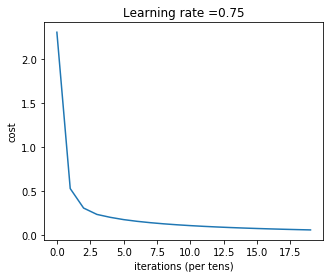

[2.3007578160931543, 0.5275205843403631, 0.3065937493520514, 0.23428468301671979, 0.20130898369226924, 0.1754680964273873, 0.15617497007437975, 0.1406181897000846, 0.12763681007426475, 0.11667649211451812, 0.10723386099441738, 0.09900051307322981, 0.09179426870090072, 0.08541869090145242, 0.07972611241592005, 0.07460175207198513, 0.06998154240660336, 0.065800151662183, 0.062001355180543616, 0.058541354665616274]
1746.6171641349792


In [0]:
import time
st = time.time()
parameters = L_layer_model(X_train, Y_train, layer_dims, 0.75, 1000, True)
ed = time.time()
print(ed -st)

In [0]:
import pickle
pickle.dump(parameters, open("model.sav", 'wb'))
#files.download("model.sav")


In [0]:
uploaded = files.upload()

Saving test.csv to test.csv


In [0]:
import pandas as pd
np_arr = pd.read_csv(io.BytesIO(uploaded["test.csv"])).values
X_test = np_arr.T
X_test = X_test/255

AL, _ = L_model_forward(X_test, parameters)
predictions = np.argmax(AL, axis=0)

NameError: ignored

In [0]:
predictions = predictions.reshape(predictions.shape[0], 1)

In [0]:
predictions = pd.DataFrame(predictions, columns = ['Label'])
predictions.index += 1
predictions.to_csv("predic3.csv")

In [0]:
files.download("predic3.csv")